In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time 

In [2]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.3 MB/s eta 0:00:00


In [3]:
!unzip open.zip

Archive:  open.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
base_path = "."
# train 변수에 train.csv 데이터를 불러옵니다.
# test 변수에 test.csv 데이터를 불러옵니다.
# submission 변수에 sample_submission.csv 데이터를 불러옵니다.
train = pd.read_csv(f'{base_path}/train.csv')
test = pd.read_csv(f'{base_path}/test.csv')
submission = pd.read_csv(f'{base_path}/sample_submission.csv')

train.shape, test.shape

((30200, 14), (12943, 13))

In [5]:
# 변수 설정

X = train.drop(columns=["ID", "전화해지여부"])
y = train["전화해지여부"]
test = test.drop(columns="ID")

In [6]:
# train_test_split 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.15, 
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25670, 12), (4530, 12), (25670,), (4530,))

In [7]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# model_xgb
model_xgb = xgb.XGBClassifier(random_state=42)

# gridsearch
# 후보 파라미터 선정
param_grid_xgb={
    'n_estimators' : [100,200,300,400,500,600,700,800,900,1000],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : range(1, 11),
    'colsample_bytree' : [0.8,0.9]}

# gridsearchcv 객체 정보 입력
xgb_gridcv = GridSearchCV(model_xgb, param_grid = param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring="f1_micro")

# 파라미터 튜닝 시작
xgb_gridcv.fit(X_train, y_train)

#튜닝된 파라미터 출력
print(xgb_gridcv.best_params_)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


KeyboardInterrupt: ignored

In [8]:
import xgboost as xgb
# 최적 파라미터 적용
xgb_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.15, max_depth=8, colsample_bytree=0.9)

# xgb_model = xgb_gridcv.best_estimator_

# 학습
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# from sklearn.model_selection import cross_val_predict

# y_train_predict = cross_val_predict(xgb_model, X_train, y_train, cv=5, n_jobs=-1, verbose=1)
# y_train_predict

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# accuracy = accuracy_score(y_train, y_train_predict)
# recall = recall_score(y_train, y_train_predict)
# f1 = f1_score(y_train, y_train_predict)
# f1_micro = f1_score(y_train, y_train_predict, average='micro')

# print(accuracy, recall, f1, f1_micro)

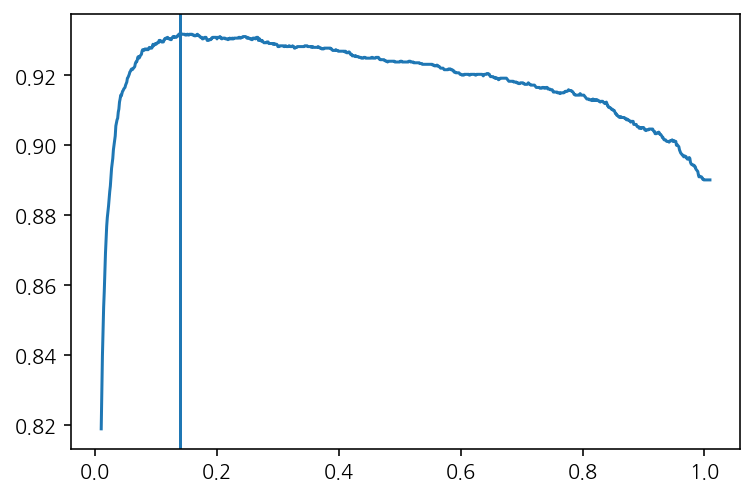

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
xgb_proba = xgb_model.predict_proba(X_test)[:,1]

thr_list = np.arange(0.01,1.01,0.001)
f1_list = []
for _ in thr_list:
    result = np.where(xgb_proba > _,1,0)
    f1_list.append(f1_score(y_test,result, average='micro'))
    

idx = np.argmax(f1_list)

plt.plot(thr_list,f1_list)
plt.axvline(thr_list[idx])

In [11]:
idx

129

In [12]:
high = xgb_model.predict_proba(test)[:,1]

In [13]:
submission["전화해지여부"] = np.where(high > thr_list[idx], 1, 0)
submission["전화해지여부"].value_counts()

0    11532
1     1411
Name: 전화해지여부, dtype: int64

In [14]:
submission.to_csv("XGBoost_raw(0.15).csv", index=False)

In [15]:
pd.read_csv("XGBoost_raw(0.15).csv")

,ID,전화해지여부
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,1
4,TEST_00004,1
...,...,...
12938,TEST_12938,0
12939,TEST_12939,0
12940,TEST_12940,0
12941,TEST_12941,0
